In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#4.1 누락된 데이터 처리

In [2]:
import pandas as pd
from io import StringIO
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# 파이썬 2.7을 사용하는 경우
# 다음처럼 문자열을 유니코드로 변환해야 합니다.
# csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


###1.1 특성마다 누락된 데이터 개수 확인

In [3]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [4]:
# values로 numpy array를 얻을 수 있다.
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

###1.2 누락된 데이터 제외하기

In [5]:
# 누락된 값이 있는 행 삭제

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
# 누락된 값이 있는 열 삭제

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [7]:
# 모든 열이 NaN일 때만 행을 삭제

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
# 실수 값이 4개보다 작은 행을 삭제합니다

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [9]:
# 특정 열에 NaN이 있는 행만 삭제합니다(여기서는 ‘C’열).

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


###1.2 누락된 값 대체하기

- 유용한 데이터를 너무 많이 잃을 수 있으므로 값을 대체한다.

In [10]:
import numpy as np
from sklearn.impute import SimpleImputer

print(df.values)
# sklearn을 이용해서 NaN값을 해당 특성(열)의 데이터 평균값으로 대체
simr = SimpleImputer(missing_values=np.nan, strategy='mean')
simr = simr.fit(df.values)
imputed_data = simr.transform(df.values)
imputed_data

[[ 1.  2.  3.  4.]
 [ 5.  6. nan  8.]
 [10. 11. 12. nan]]


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [11]:
from sklearn.preprocessing import FunctionTransformer
# sklearn을 이용해서 NaN값을 해당 샘플(행)의 데이터 평균값으로 대체
ftr_simr = FunctionTransformer(lambda X: simr.fit_transform(X.T).T, validate=False)
imputed_data = ftr_simr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

#4.2 범주형 데이터 다루기 ( 순서 o, 순서 x)

### 4.2.1 순서가 있는 특성과 없는 특성

In [12]:
import pandas as pd


df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 4.2.2 순서가 있는 특성은 매핑

In [13]:
size_mapping = {'XL' : 3, 'L' : 2, 'M' : 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


### 매핑한 값을 다시 문자열로 바꾸는 방법

In [14]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

###4.2.3 클래스 레이블 인코딩

- 여러 모듈의 분류 추정기는 클레스 레이블을 자체적으로 정수로 변환해주지만, 클래스 레이블을 정수로 인코딩해주는 습관이 필요

In [15]:
import numpy as np
# {}은 내부 연산(?)된 값들을 dict형태로 만든다.
class_mapping = {label:idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [16]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


- 다른 방법으로 사이킷런 LabelEncoder 클래스를 사용해도 된다.

In [17]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

###4.2.4 순서가 없는 특성에 원-핫 인코딩 적용

In [18]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:,0] = color_le.fit_transform(X[:,0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

- 위와 같이 green, red, blue를 0, 1, 2로 매핑한다면 red를 green 보다 크다고 가정할 것이다.
- 이러한 문제를 해결하기 위해서 **원-핫 인코딩 기법**을 사용한다.

- 이 기법은 순서 없는 특성에 들어있는 고유한 값마다 새로운 특성을 만드는 것이다.


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=np.int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

In [20]:
from sklearn.preprocessing import OneHotEncoder

oh_enc = OneHotEncoder(categories='auto')
col_trans = ColumnTransformer([('oh_enc', oh_enc, [0])], remainder='passthrough')
col_trans.fit_transform(X)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


- 아래는 pandas의 원-핫 인코딩입니다.
- One-hot incoding으로 더미 변수를 만드는 더 편리한 방법
- 특성을 지정해주면 자기가 알아서 one-hot incdoing으로 만든다.

In [21]:
# 판다스의 원-핫 인코딩

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [22]:
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


In [23]:
# get_dummies에서 다중 공선성 문제를 피하려면
# 첫번째 열인 color_blue 열을 삭제했다.
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


#4.3 데이터셋을 훈련 세트와 테스트 세트로 나누기

In [24]:
# 와인 샘플 178개의 화학 성분을 나타내는 Wine 데이터셋의 특성 13개이다.

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
177,3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [25]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('클래스 레이블', np.unique(df_wine['Class label']))
df_wine.head()

클래스 레이블 [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


- 사이킷런 모듈로 train, test 나누기

In [26]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# stratify=y 처럼 클래스 레이블 배열 y를 전달하면 train set, test set에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지된다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

#4.4 특성 스케일 맞추기

- Decision tree, Randomforest는 특성 스케일 조정에 영향을 받지 않지만, 경사 하강법 알고리즘은 큰 성능 차이를 보인다.
- 예를 들어서, 
      첫번째 특성이 (1 ~ 10)
      두번째 특성이 (1 ~ 10000000)

(1) 아달린에서 weight를 업데이트 시키는 부분에서 두번째 특성에 대한 큰 오차에 맞추어서 가중치를 최적화 할 것이다.

(2) KNN에서 두번째 특성 축에 좌우될 것이다.

-> 그러므로 특성끼리 스케일을 맞춰주는 정규화 or 표준화를 사용


###4.4.1 최소-최대 스케일 변환 (정규화)

In [27]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)
X_test_norm[:5]

array([[0.81547619, 0.26954178, 0.84615385, 0.39634146, 0.41975309,
        0.69090909, 0.70731707, 0.44897959, 0.44250871, 0.53404255,
        0.5042735 , 0.62357414, 0.90987124],
       [0.33928571, 0.14824798, 0.75      , 0.51219512, 0.28395062,
        0.28727273, 0.3902439 , 0.57142857, 0.21602787, 0.17765957,
        0.77777778, 0.35741445, 0.03433476],
       [1.        , 0.26145553, 0.69871795, 0.24390244, 0.18518519,
        0.50909091, 0.625     , 0.26530612, 0.54703833, 0.42234043,
        0.41025641, 0.87072243, 0.83690987],
       [0.64583333, 0.23719677, 0.5       , 0.03658537, 0.2345679 ,
        0.56363636, 0.69817073, 0.18367347, 0.30313589, 0.32978723,
        0.43589744, 0.80228137, 0.63090129],
       [0.39880952, 0.0458221 , 0.47435897, 0.48170732, 0.08641975,
        0.88      , 1.        , 0.14285714, 0.53658537, 0.34255319,
        0.42735043, 0.56273764, 0.29613734]])

###4.4.2 표준화

In [28]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('표준화:', (ex - ex.mean()) / ex.std())
# 판다스는 기본적으로 ddof=1(샘플 표준 편차)을 사용합니다.
# 넘파이의 std 메서드와 사이킷런의 StandardScaler는 ddof=0(모집단 표준 편차)를 사용합니다.
print('정규화:', (ex - ex.min()) / (ex.max() - ex.min()))

표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
정규화: [0.  0.2 0.4 0.6 0.8 1. ]


In [29]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_test_std[:5]

array([[ 0.89443737, -0.38811788,  1.10073064, -0.81201711,  1.13201117,
         1.09807851,  0.71204102,  0.18101342,  0.06628046,  0.51285923,
         0.79629785,  0.44829502,  1.90593792],
       [-1.04879931, -0.77299397,  0.54119006, -0.24093881,  0.3494145 ,
        -0.70721922, -0.30812129,  0.67613838, -1.03520519, -0.90656727,
         2.24570604, -0.56188171, -1.22874035],
       [ 1.64744158, -0.41377628,  0.24276841, -1.56343594, -0.21974672,
         0.28488133,  0.44719119, -0.561674  ,  0.57465846,  0.06796436,
         0.29806378,  1.38631627,  1.64471473],
       [ 0.2021593 , -0.4907515 , -0.91361545, -2.58536553,  0.06483389,
         0.52884049,  0.68261326, -0.89175731, -0.61155686, -0.30066282,
         0.4339458 ,  1.12655654,  0.90714337],
       [-0.80589473, -1.09800044, -1.06282627, -0.39122257, -0.78890794,
         1.94380357,  1.6537293 , -1.05679896,  0.52382066, -0.2498177 ,
         0.38865179,  0.21739748, -0.29141008]])

#4.5 유용한 특성 선택

- 모델이 테스트 세트보다 훈련 세트에서 성능이 훨씬 좋다면 과대적합이다. ( 분산 : 낮다, 바이어스 : 높다 )
- 모델 파라미터가 훈련 세트에 있는 특정 샘플들에 대해 너무 가깝게 맞추어져 있다는 의미이다.
- 새로운 데이터에 잘 일반화하지 못하므로 분산이 크다고 말한다.
- 이유는 모델이 너무 복잡한 것이다.

    방법 1 : Regularization

    방법 2 : 차원 축소 (SBS 사용) 

    방법 3 : 랜덤 포레스트 사용

### 해결방법

1. 더 많은 훈련 데이터를 모은다. ((예) GAN 방식)
2. 규제를 통해 복잡도를 제한한다.
3. 파라미터 개수가 적은 간단한 모델을 선택한다.
4. 데이터 차원을 축소 시킨다.

###4.5.1 모델 복잡도 제한을 위한 L1 규제와 L2 규제

- L2 규제는 개별 가중치 값을 제한하여 모델 복잡도를 줄이는 방법

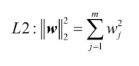

- L1 규제는 가중치 제곱을 그냥 가중치 절댓값으로 바꾼것이다.
- L1 규제는 보통 희소한 특성 벡터를 만든다. 
- 대부분의 특성 가중치가 0이 되면서 관련 없는 특성이 많은 고차원 데이터셋은 이런 희소성이 도움이 될 수 있다. ( 특히, 샘플보다 관련 없는 특성이 더 많은 경우 )

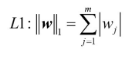

In [30]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1')
# 여기서 C가 람다(Reguraization parameter)의 역수이다. 
lr = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1', C=1.0, random_state=42)
lr.fit(X_train_std, y_train)
lr.score(X_train_std, y_train)

1.0

In [31]:
# X_test_norm은 엄청 낮은 정확도가 나온다
lr.score(X_test_std, y_test)

1.0

###4.5.2 규제 강도를 달리한 가중치의 변화

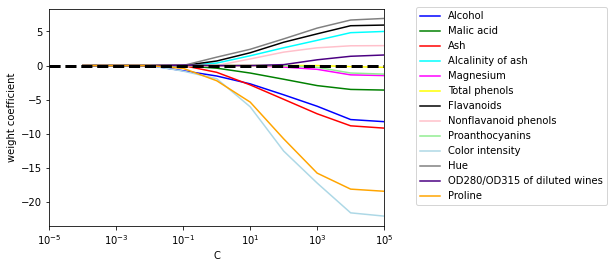

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear', multi_class='auto',
                            penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

- 각 feature에 대해서 규제를 매우 낮춘 결과
- 그래프 오른쪽을 보면 람다가 매우 작아진 상태이고 패널티가 오히려 너무작아서 가중치의 더 변화가 요구된다. 즉, 각 특성마다 가중치의 coefficient가 크게 바뀌는 것을 볼 수 있다.
- 규제가 강할수록 연산이 느리므로(?) 그래프상 C : 10^-2 만큼의 규제가 빠른 연산에 적당한 규제가 가능할 것으로 보인다.

###4.5.3 순차 특성 선택 알고리즘 ( 차원 축소 )

- 모델의 유용한 특성을 고르기 위한 차원 축소 방법을 사용
- 차원축소는 ( 특성선택, 특성 추출 )이 있다.

- 특성 선택 : 원본 특성에서 일부를 선택한다
- 특성 추출 : 일련의 특성에서 얻은 정보로 새로운 특성을 만든다. **굵은 텍스트**

- 먼저, 특성 선택 알고리즘인 순차 후진 선택 ( Sequential Backward Selection, SBS)

설명 : 순차 특성 선택 알고리즘은 Greedy search Algorithm으로 d차원 공간을 k < d 일 때, k차원의 특성 부분 공간으로 축소한다.

1. 주어진 문제에 가장 관련이 높은 특성 부분 집합을 자동으로 선택하는 것이 목적
2. 관계없는 특성이나 잡음을 제거하여 계산 효율성을 높이고 모델의 일반화 오차를 줄일 수 있다. 규제를 제공하지 않는 알고리즘을 사용할 때 유용하다.

3. SBS의 아이디어는 새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거한다.

    -> 쉽게 말해서 기준 함수에서 계산한 값은 어떤 특성을 제거하기 전후의 모델 성능 차이이로, 각 단계에서 제거했을 때 성능 손실이 최대가 되는 특성을 제거한다.

#####순서

1. 알고리즘을 K = d로 초기화.
2. 조건 **x**'=argmax(J(**X밑(k)**-**x**))를 최대화하는 특성 x'을 결정한다. 여기서 x 는 X밑(k)에 포함
3. 특성 집합에서 특성 x'을 제거한다.
4. k가 목표하는 특성 개수가 되면 종료한다. 아니면 2단계로 돌아간다.


In [33]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        # 없애고 성능 측정 시 가장 좋은 성능을 보이는 특성들을 하나씩 제거해나가면서 차원을 축소한다.
        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            # 기장 점수가 좋은 score 위치 index를 best에 담고 그것을 subsets에 매핑하여 그 특성을 찾아낸다.
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

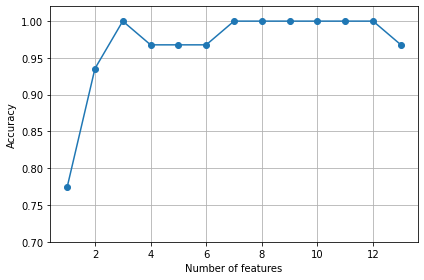

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)


# 특성 조합의 성능 그래프를 출력합니다.
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

- 가장 좋은 특성 개수에 따른 점수를 볼 수 있다.

In [35]:
# 각 feature의 개수에 대한 최적화된 feature들
a = [_ for _ in list(sbs.subsets_)]
a

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 11),
 (0, 1, 2, 3, 4, 5, 7, 9, 11),
 (0, 1, 2, 3, 5, 7, 9, 11),
 (0, 1, 2, 3, 5, 7, 11),
 (0, 1, 2, 3, 5, 11),
 (0, 1, 2, 3, 11),
 (0, 1, 2, 11),
 (0, 1, 11),
 (0, 11),
 (0,)]

In [36]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

k7 = list(sbs.subsets_[6])
print(df_wine.columns[1:][k7])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')
Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Total phenols',
       'Nonflavanoid phenols', 'OD280/OD315 of diluted wines'],
      dtype='object')


### 기존 데이터, 차원 축소된 데이터 성능 차이 ( KNN 적용 )

In [37]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [38]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


- 테스트 정확도가 조금 떨어지는 것을 볼 수 있지만 feature를 13 -> 3개로 줄이면서 이 정도 결과는 매우 효과적이라고 할 수 있다.

#4.6 랜덤 포레스트의 특성 중요도 사용

- 랜덤 포레스트를 사용해서 앙상블에 참여한 모든 결정 트리에서 계산한 평균적인 불순도 감소로 특성 중요도를 측정할 수 있다.

- 데이터셋이 선형적으로 구분 가능한지 여부를 가정할 필요가 없다.

- Randomforest 훈련 후에 feature_importance 속성으로 확인 가능

- Flow

    n개의 트리르 가진 랜덤 포레스트를 훈련하고 각각의 중요도에 따라 13개의 특성에 순위를 매긴다.
    ( 트리 기반 모델은 표준화, 정규화가 필요 없다. )

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


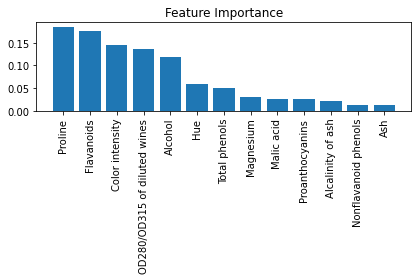

In [39]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [40]:
knn.fit(X_train_std[:, [12, 9, 6]], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, [12, 9, 6]], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, [12, 9, 6]], y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9814814814814815


- 랜덤포레스트로 유용한 특성을 찾은 특성 3개로 모델을 돌린결과 98%의 결과가 나온 것을 볼 수 있다.
- 순차 선택 특성 알고리즘(SBS)를 사용하여서 찾은 특성보다 훨씬 좋은 특성을 찾은 결과를 볼 수 있다.

In [41]:
from sklearn.feature_selection import SelectFromModel

# 임계값을 주어서 feature의 중요도가 0.1 이상인 feature를 가지고 모델을 사용한다
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:', X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


In [42]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
